In [1]:
# DASK client set

import os
import sys
from dask.distributed import Client
# client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler.json', threads_per_worker=2, n_workers=6)
# client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler.json')
client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler_10.json')  

# add private module path for workers
# client.run(lambda: os.environ.update({'PYTHONPATH': '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2'}))
# def add_path():
#     if '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2' not in sys.path:
#         sys.path.append('/proj/kimyy/Dropbox/source/python/all/Modules/CESM2')

# client.run(add_path)

def setup_module_path():
    module_path = '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2'
    if module_path not in sys.path:
        sys.path.append(module_path)

client.run(setup_module_path)

client

# get path for path changes in Jupyter notebook: File - Open from Path - insert relative_path
notebook_path = os.path.abspath(".")
_, _, relative_path = notebook_path.partition('/all/')
relative_path = '/all/' + relative_path
relative_path

'/all/Model/CESM2/Earth_System_Predictability/DIC'

# Load modules

In [2]:
# load public modules

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import matplotlib.ticker as mticker
import matplotlib.path as mpath
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
from scipy.interpolate import griddata
import cmocean
from cmcrameri import cm
import warnings
warnings.simplefilter(action='ignore')
import pandas as pd
import cftime
import pop_tools
from pprint import pprint
import time
import subprocess
import re as re_mod
import cftime
import datetime
from scipy.stats import ttest_1samp

In [3]:
# load private modules

import sys
sys.path.append('/proj/kimyy/Dropbox/source/python/all/Modules/CESM2')
from KYY_CESM2_NWP_preprocessing import CESM2_NWP_config
# import KYY_CESM2_preprocessing
# import importlib
# importlib.reload(KYY_CESM2_preprocessing)

# Variable configuration

In [4]:
# 1. DIC (Total)
cfg_var_DIC=CESM2_NWP_config()
cfg_var_DIC.year_s=1960
cfg_var_DIC.year_e=2020
cfg_var_DIC.setvar('DIC')

# 2. TEMP (Total)
cfg_var_TEMP=CESM2_NWP_config()
cfg_var_TEMP.year_s=1960
cfg_var_TEMP.year_e=2020
cfg_var_TEMP.setvar('TEMP')

if cfg_var_DIC.comp=='ocn':
    ds_grid = pop_tools.get_grid('POP_gx1v7')

# Read dataset

In [5]:
# define preprocessing function

exceptcv=['time','lon','lat','lev', 'TAREA', 'TLONG', 'TLAT', 'z_t', 'dz', cfg_var_DIC.var, cfg_var_TEMP.var]
def process_coords_3d(ds, sd, ed, drop=True, except_coord_vars=exceptcv):
    """Preprocessor function to drop all non-dim coords, which slows down concatenation."""
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]
    
    if drop:
        ds= ds.drop(coord_vars)
        ds= ds.sel(time=slice(sd, ed))
        ds = ds.isel(z_t=slice(1, 39)) # ~39 layer (1000m)
        # ds = (ds.isel(z_t=slice(1, 39)) * ds.dz).sum(dim='z_t') / ds.dz.sum(dim='z_t')
        return ds
    else:
        return ds.set_coords(coord_vars)


# exceptcv=['time','lon','lat','lev', 'TLONG', 'TLAT', 'z_t', cfg_var_DIC.var, cfg_var_Li_diat.var, cfg_var_Li_sp.var,
#          cfg_var_Vi_diat_Fe.var, cfg_var_Vi_diat_N.var, cfg_var_Vi_diat_P.var, cfg_var_Vi_diat_SiO3.var,
#          cfg_var_Vi_sp_Fe.var, cfg_var_Vi_sp_N.var, cfg_var_Vi_sp_P.var,
#          cfg_var_NPP_diat.var, cfg_var_NPP_sp.var]
# def process_coords(ds, sd, ed, drop=True, except_coord_vars=exceptcv):
#     """Preprocessor function to drop all non-dim coords, which slows down concatenation."""
#     coord_vars = []
#     for v in np.array(ds.coords) :
#         if not v in except_coord_vars:
#             coord_vars += [v]
#     for v in np.array(ds.data_vars) :
#         if not v in except_coord_vars:
#             coord_vars += [v]
    
#     if drop:
#         ds= ds.drop(coord_vars)
#         ds= ds.sel(time=slice(sd, ed))
#         return ds
#     else:
#         return ds.set_coords(coord_vars)

start_date = cftime.DatetimeNoLeap(cfg_var_DIC.year_s, 2, 1)
end_date = cftime.DatetimeNoLeap(cfg_var_DIC.year_e+1, 1, 1)


# ds = ds.isel(lev=slice(1, 11))

In [6]:
# Read LE dataset

# Quicker test for 2 ensembles only

start_time = time.time()

#TEMP
cfg_var_TEMP.LE_path_load(cfg_var_TEMP.var)
cfg_var_TEMP.LE_ds = xr.open_mfdataset(cfg_var_TEMP.LE_file_list[0][0:10], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_TEMP.LE_ensembles[0:10]], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_3d(ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)      
# cfg_var_TEMP.LE_ds = xr.open_mfdataset(cfg_var_TEMP.LE_file_list[0], 
#                        chunks={'time': 12}, 
#                        combine='nested', 
#                        concat_dim=[[*cfg_var_TEMP.LE_ensembles], 'time'], 
#                        parallel=True,
#                        preprocess=lambda ds: process_coords_3d(ds, start_date, end_date),
#                        decode_cf=True, 
#                        decode_times=True)      

cfg_var_TEMP.LE_ds = cfg_var_TEMP.LE_ds.rename({"concat_dim": "ens_LE"})
new_time = cfg_var_TEMP.LE_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_TEMP.LE_ds.time))
cfg_var_TEMP.LE_ds = cfg_var_TEMP.LE_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading LE: ' + str(elapsed_time))

elasped time for reading LE: 19.056308269500732


In [7]:
# Read ODA dataset

# Quicker test for 2 ensembles only

start_time = time.time()

#TEMP
cfg_var_TEMP.ODA_path_load(cfg_var_TEMP.var)
cfg_var_TEMP.ODA_ds = xr.open_mfdataset(cfg_var_TEMP.ODA_file_list[0][0:10], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_TEMP.ODA_ensembles[0:10]], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_3d(ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)      

cfg_var_TEMP.ODA_ds = cfg_var_TEMP.ODA_ds.rename({"concat_dim": "ens_ODA"})
new_time = cfg_var_TEMP.ODA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_TEMP.ODA_ds.time))
cfg_var_TEMP.ODA_ds = cfg_var_TEMP.ODA_ds.assign_coords(time=new_time)


# cfg_var_TEMP.ODA_path_load(cfg_var_TEMP.var)
# cfg_var_TEMP.ODA_file_list[0]

# identify STMW

In [8]:
def identify_edw_model(ds_T, mesh=ds_grid, strat_crit=0.00015, temp_crit=[16, 20], return_thickness=True, minimum_thickness=5000):
    """
    Identify EDW in a model dataset.

    NASTMW
    dT/dz < 1.0°C/100 m
    temperature range of 16–22°C

    NPSTMW
    temperature range of 16°C and 18°C, 
    dT/dz <1.5°C per 100m
    
    Parameters
    ----------
    ds_T : xarray.Dataset
        Dataset containing the temperature variable.
    mesh : xarray.Dataset
        Dataset containing the mesh variables.
    strat_crit : float
        Stratification criterion. Default from literature.
    temp_crit : list
        Temperature criterion. Default from literature
    return_thickness : bool
        If True, returns the thickness of the identified EDW layer.

    Returns
    -------
    criterion_edw : xarray.DataArray
        Boolean array with True where EDW is identified.
    edw_thickness : xarray.DataArray
        Thickness of the identified EDW layer.
    """
    
    T_grad = ds_T.TEMP.differentiate(coord='z_t')

    # judge by temperature and stratification criterion
    criterion_temperature = (ds_T.TEMP > temp_crit[0]) * (ds_T.TEMP < temp_crit[1])
    criterion_strat = np.fabs(T_grad) < strat_crit
    ds_T['criterion_edw'] = criterion_strat * criterion_temperature

    if return_thickness:
        # cell_thickness_3d = mesh.z_t.rename({'z_t': 'deptht'}).assign_coords(deptht=criterion_edw.deptht) * (criterion_edw * 0 + 1)
        # edw_thickness = cell_thickness_3d.where(criterion_edw).sum(dim='deptht', skipna=True)

        ds_T['cell_thickness_3d'] = xr.DataArray(ds_T.dz).broadcast_like(ds_T['TEMP'])
        ds_T['edw_thickness'] = ds_T['cell_thickness_3d'].where(ds_T['criterion_edw']).sum(dim='z_t', skipna=True)

        ds_T['criterion_edw'] = ds_T['criterion_edw'].where(ds_T['edw_thickness'] > minimum_thickness, False)
        ds_T['edw_thickness'] = ds_T['edw_thickness'].where(ds_T['edw_thickness'] > minimum_thickness, 0)
        
        return ds_T
    else:
        return criterion_edw




In [9]:
def compute_edw_volume(ds_T, mesh=ds_grid, strat_crit=0.00015, temp_crit=[16, 20], tvar='TEMP', return_cells=True):
    """
    Compute the volume of EDW in a model dataset.

    NASTMW
    dT/dz < 1.0°C/100 m
    temperature range of 16–22°C

    NPSTMW
    temperature range of 16°C and 18°C, (sysong : 16~20)
    dT/dz <1.5°C per 100m
    
    Parameters
    ----------
    ds_T : xarray.Dataset
        Dataset containing the temperature variable.
    mesh : xarray.Dataset
        Dataset containing the mesh variables.
    strat_crit : float
        Stratification criterion. Default from literature.
    temp_crit : list
        Temperature criterion. Default from literature
    tvar : str
        Name of the temperature variable in ds_T.
    return_cells : bool
        If True, returns the volume of each cell.

    Returns
    -------
    total_volume : xarray.DataArray
        Total volume of EDW.
    edw_volume : xarray.DataArray
        Volume of each cell identified as EDW.
    criterion_edw : xarray.DataArray
        Boolean array with True where EDW is identified.
    """
    
    if type(ds_T) == xr.Dataset:
        da_T = ds_T[tvar]
    elif type(ds_T) == xr.DataArray:
        da_T = ds_T
    else:
        raise

    T_grad = da_T.differentiate(coord='z_t')

    criterion_temperature = (da_T > temp_crit[0]) * (da_T < temp_crit[1])
    criterion_strat = np.fabs(T_grad) < strat_crit
    ds_T['criterion_edw'] = criterion_strat * criterion_temperature

    
    
    # volume = (mesh.e3t_0 * mesh.e2t * mesh.e1t)
    # volume = volume.where(volume < 100e3 * 100e3 * 500e3).where(volume >= 0)
    # volume = volume.rename({"z": "deptht"}).assign_coords(deptht=criterion_edw.deptht) * (criterion_edw * 0 + 1)
    # edw_volume = volume.where(criterion_edw)
    # total_volume = edw_volume.sum(skipna=True)

    if return_cells:
        ds_T['cell_thickness_3d'] = xr.DataArray(ds_T.dz).broadcast_like(ds_T['TEMP']) / 100
        ds_T['TAREA_3d'] = xr.DataArray(ds_T.TAREA).broadcast_like(ds_T['TEMP']) / 10000
        ds_T['volume'] = ds_T['cell_thickness_3d'] * ds_T['TAREA_3d']
        ds_T['edw_volume'] = (ds_T['volume'] * ds_T['criterion_edw'])
        ds_T['edw_total_volume'] = ds_T['edw_volume'].sum(dim='z_t', skipna=True)
    
        return ds_T
    else:
        return total_volume

NameError: name 'pop_add_cyclic' is not defined

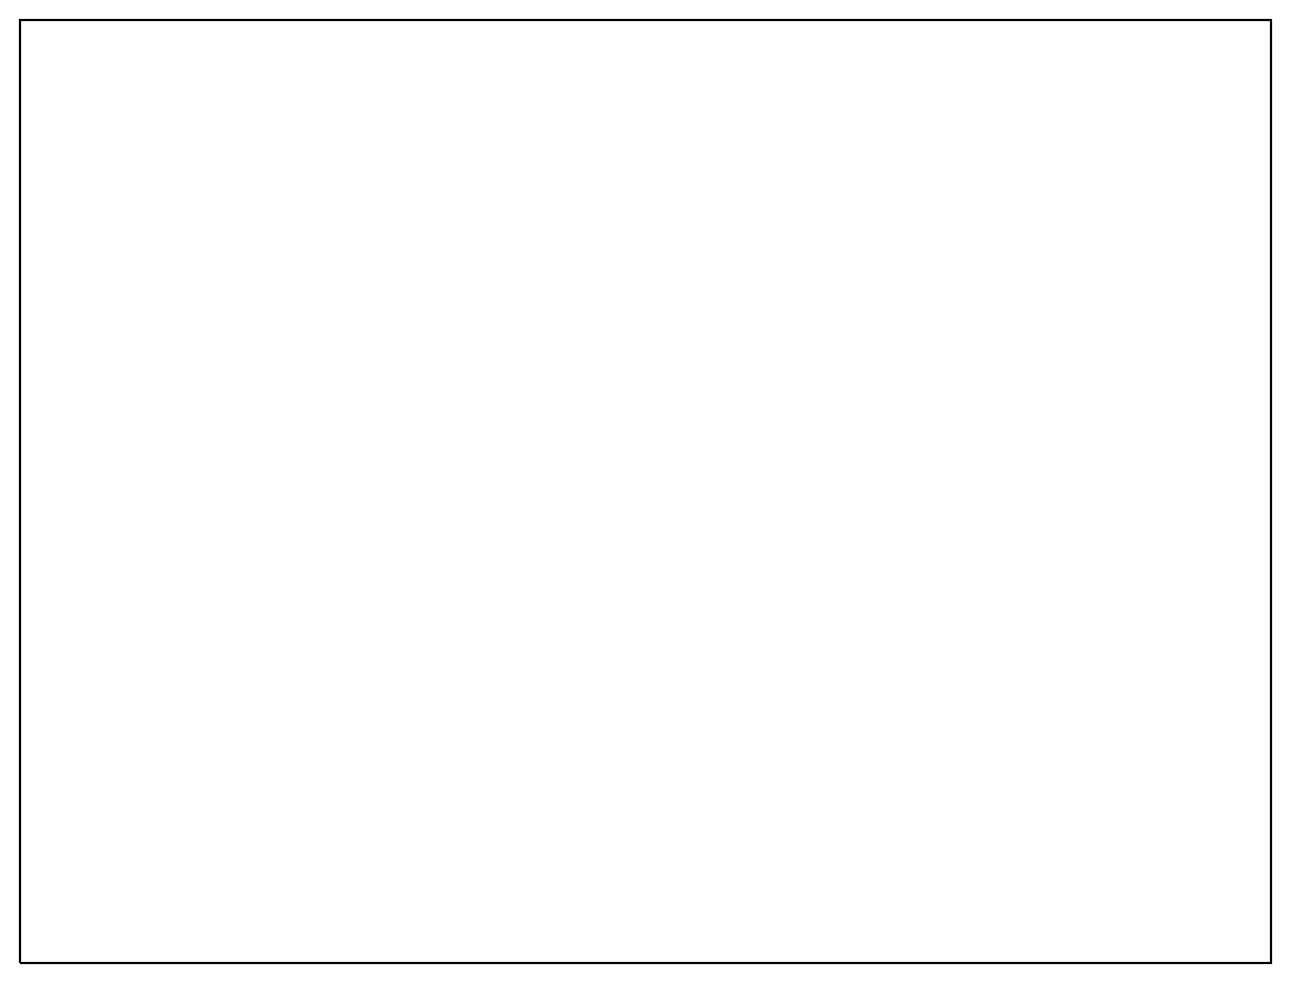

In [10]:
# # edw_criterion, edw_thickness =identify_edw_model(cfg_var_TEMP.LE_ds, ds_grid)
# identify_edw_model(cfg_var_TEMP.LE_ds, ds_grid)

# # ax = plt.subplot(gs[0,0]); ax.set_title('LE2', fontsize=17)

# data1 = cfg_var_TEMP.LE_ds['edw_thickness']=cfg_var_TEMP.LE_ds['edw_thickness'].where(cfg_var_TEMP.LE_ds['edw_thickness'] != 0, np.nan)
# data1 = data1.mean(dim='time').mean(dim='ens_LE')/100;


# #cf1, lon1, lat1 = contour_map(data1, levs, domain, cmap, 'neither', f_size=13, xset=1.3, yset=1.3)
# #cf = plt.contourf(lonproj, latproj, data, levs, cmap=cmap, extend=extend)
# # proj.drawcoastlines(linewidth=0.5)
# #proj.fillcontinents(color='lightgrey', lake_color='none')

# data1['TLONG']=cfg_var_TEMP.LE_ds.TLONG
# data1['TLAT']=cfg_var_TEMP.LE_ds.TLAT

# cmap = plt.cm.tab20c;

# projection = ccrs.Robinson(central_longitude=145)
# fig, axes = plt.subplots(nrows=1, ncols=1, 
#              dpi=200, facecolor='w', edgecolor='k', subplot_kw={'projection': projection}, constrained_layout=True)
# axes.set_extent([120, 180, 20, 60], crs=ccrs.PlateCarree())  # Longitude range (120 to 170), Latitude range (0 to 50)

# plt1=pop_add_cyclic(data1).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes, vmin=36, vmax=202,
#                         transform=ccrs.PlateCarree(), cmap=cmap)

# # plot.pcolormesh(data1, ax=axes, vmin=36, vmax=202,
# #                         transform=ccrs.PlateCarree(), cmap=cmap)
# axes.coastlines()
# # axes.gridlines(draw_labels=True)

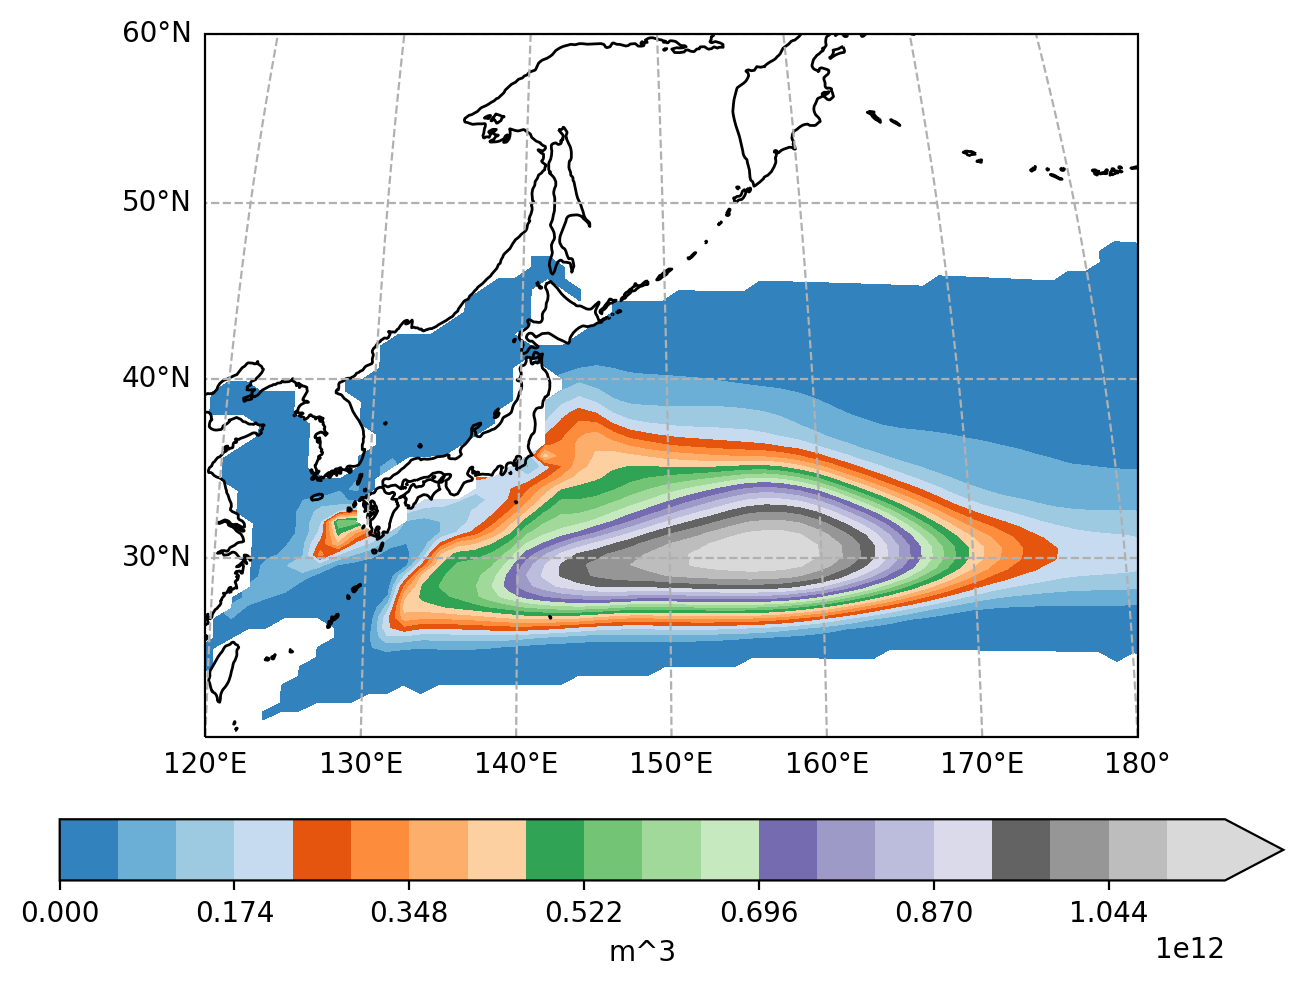

In [17]:
# mean STMW (LE)
compute_edw_volume(cfg_var_TEMP.LE_ds, ds_grid)
data1 = cfg_var_TEMP.LE_ds['edw_total_volume']
data1 = data1.mean(dim='time').mean(dim='ens_LE')
data1 = data1.where(data1 != 0, np.nan).compute()

data1['TLONG']=cfg_var_TEMP.LE_ds.TLONG
data1['TLAT']=cfg_var_TEMP.LE_ds.TLAT

cmap = plt.cm.tab20c;

projection = ccrs.Robinson(central_longitude=145)
fig, axes = plt.subplots(nrows=1, ncols=1, 
             dpi=200, facecolor='w', edgecolor='k', subplot_kw={'projection': projection}, constrained_layout=True)
axes.set_extent([120, 180, 20, 60], crs=ccrs.PlateCarree())  # Longitude range (120 to 170), Latitude range (0 to 50)



# plt1=pop_add_cyclic(data1).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes,
#                         transform=ccrs.PlateCarree(), cmap=cmap)

# set REGION = NWP
# set xw = 133
# set xe = 205
# set ys = 221
# set yn = 325

# levels = np.linspace(plt1.get_clim()[0], plt1.get_clim()[1], 21)  # 20 intervals
levels = np.linspace(np.nanmin(data1), np.nanmax(data1), 21)  # 20 intervals

plt1=axes.contourf(ds_grid.TLONG[220:325, 132:205],
             ds_grid.TLAT[220:325, 132:205],
             data1,transform=ccrs.PlateCarree(), levels=levels, cmap=cmap , add_colorbar=False, extend='max')
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=plt1.cmap.N, clip=True)
cbar1 = fig.colorbar(plt1, orientation='horizontal', boundaries=levels, norm=norm)
cbar1.set_label('m^3')
axes.coastlines()

# Adding gridlines
gl = axes.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linestyle='--')
gl.top_labels = False  # Hide top labels
gl.right_labels = False  # Hide right labels
gl.xlocator = mticker.FixedLocator(np.arange(120, 190, 10))  # Longitudes every 10°
gl.ylocator = mticker.FixedLocator(np.arange(20, 70, 10))  # Latitudes every 10°
gl.xlabel_style = {'size': 10, 'color': 'black'}  # Customize label style
gl.ylabel_style = {'size': 10, 'color': 'black'}  # Customize label style


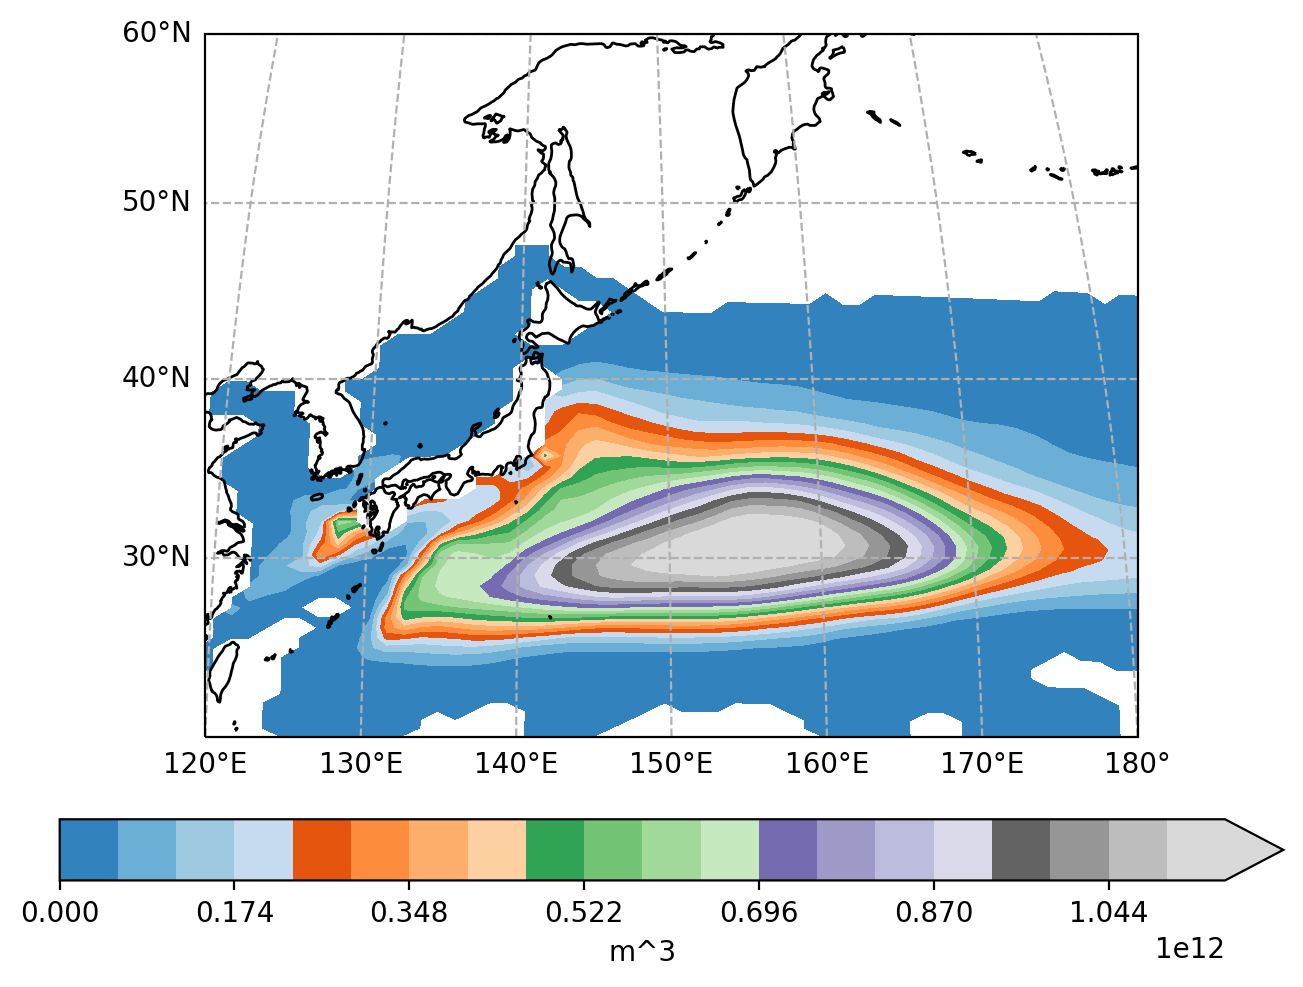

In [18]:
# mean STMW (ODA)
compute_edw_volume(cfg_var_TEMP.ODA_ds, ds_grid)
data2 = cfg_var_TEMP.ODA_ds['edw_total_volume']
data2 = data2.mean(dim='time').mean(dim='ens_ODA')
data2 = data2.where(data2 != 0, np.nan).compute()

fig, axes = plt.subplots(nrows=1, ncols=1, 
                         dpi=200, facecolor='w', edgecolor='k', subplot_kw={'projection': projection}, constrained_layout=True)
axes.set_extent([120, 180, 20, 60], crs=ccrs.PlateCarree())  # Longitude range (120 to 170), Latitude range (0 to 50)

# Define 20 levels for the contour
# levels = np.linspace(data2.min(), data2.max(), 21)  # 20 intervals (21 points)
levels = np.linspace(np.nanmin(data1), np.nanmax(data1), 21)  # 20 intervals

# Create the contourf with specified levels
plt1 = axes.contourf(ds_grid.TLONG[220:325, 132:205],
                     ds_grid.TLAT[220:325, 132:205],
                     data2, levels=levels, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False, extend='max')

# Set the color normalization with the same levels
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N, clip=True)
cbar1 = fig.colorbar(plt1, orientation='horizontal', boundaries=levels, norm=norm)
cbar1.set_label('m^3')

axes.coastlines()

# Adding gridlines
gl = axes.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linestyle='--')
gl.top_labels = False  # Hide top labels
gl.right_labels = False  # Hide right labels
gl.xlocator = mticker.FixedLocator(np.arange(120, 190, 10))  # Longitudes every 10°
gl.ylocator = mticker.FixedLocator(np.arange(20, 70, 10))  # Latitudes every 10°
gl.xlabel_style = {'size': 10, 'color': 'black'}  # Customize label style
gl.ylabel_style = {'size': 10, 'color': 'black'}  # Customize label style

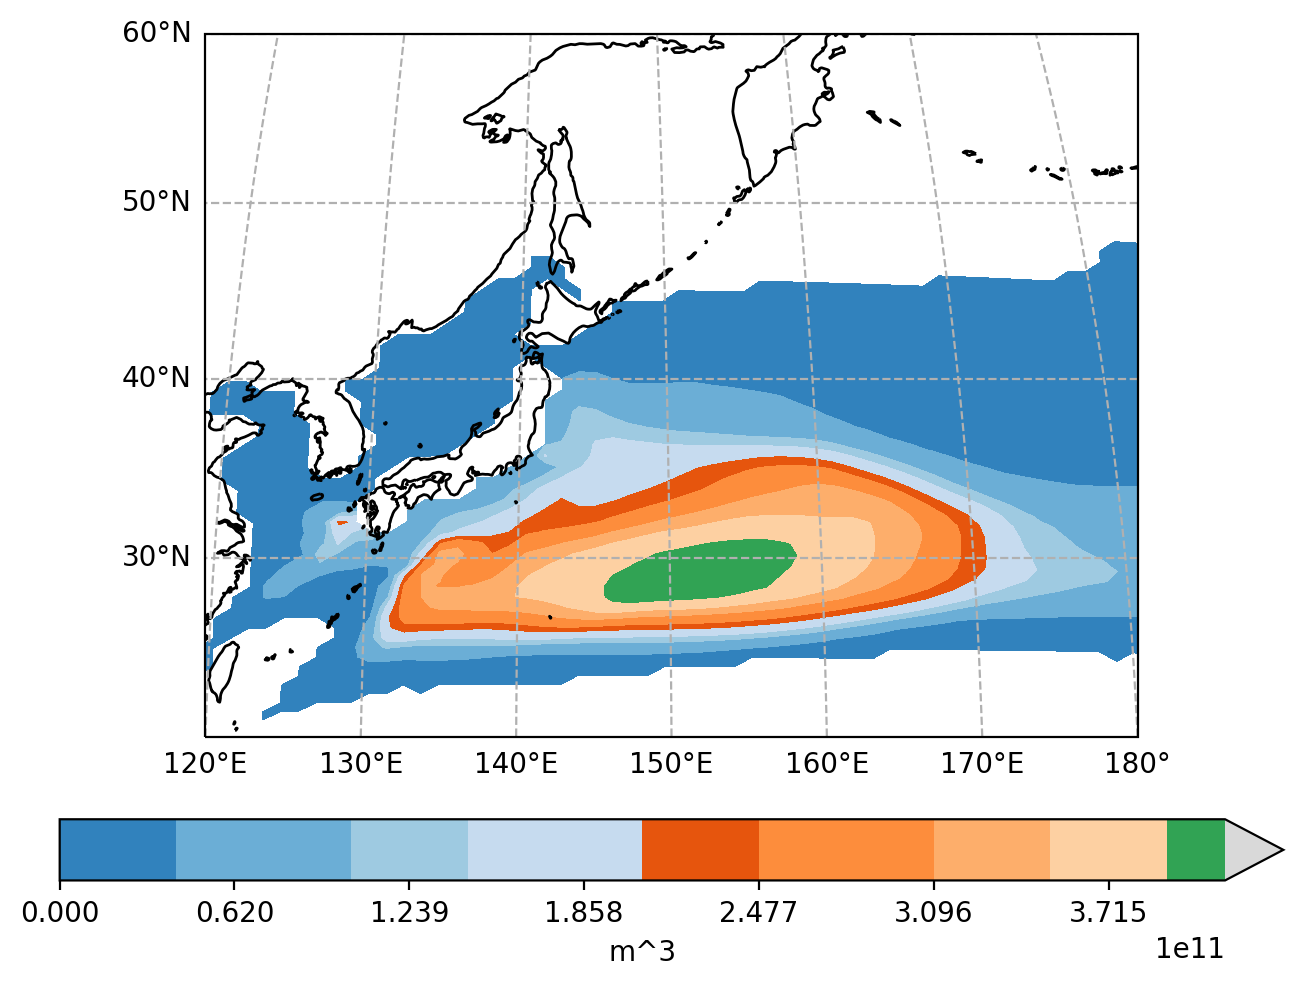

In [19]:
# std STMW (LE)
compute_edw_volume(cfg_var_TEMP.LE_ds, ds_grid)
data1 = cfg_var_TEMP.LE_ds['edw_total_volume']
# data1 = data1.std(dim='time').mean(dim='ens_LE')
data1 = data1.groupby('time.year').mean(dim='time').std(dim='year').mean(dim='ens_LE')

data1 = data1.where(data1 != 0, np.nan).compute()

data1['TLONG']=cfg_var_TEMP.LE_ds.TLONG
data1['TLAT']=cfg_var_TEMP.LE_ds.TLAT

projection = ccrs.Robinson(central_longitude=145)
fig, axes = plt.subplots(nrows=1, ncols=1, 
             dpi=200, facecolor='w', edgecolor='k', subplot_kw={'projection': projection}, constrained_layout=True)
axes.set_extent([120, 180, 20, 60], crs=ccrs.PlateCarree())  # Longitude range (120 to 170), Latitude range (0 to 50)

levels = np.linspace(np.nanmin(data1), np.nanmax(data1), 21)  # 20 intervals

plt1=axes.contourf(ds_grid.TLONG[220:325, 132:205],
             ds_grid.TLAT[220:325, 132:205],
             data1,transform=ccrs.PlateCarree(), levels=levels, cmap=cmap, vmin=0, vmax=1e12, add_colorbar=False, extend = 'max')
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=plt1.cmap.N, clip=True)
cbar1 = fig.colorbar(plt1, orientation='horizontal', boundaries=levels, norm=norm)
cbar1.set_label('m^3')
axes.coastlines()
# Adding gridlines
gl = axes.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linestyle='--')
gl.top_labels = False  # Hide top labels
gl.right_labels = False  # Hide right labels
gl.xlocator = mticker.FixedLocator(np.arange(120, 190, 10))  # Longitudes every 10°
gl.ylocator = mticker.FixedLocator(np.arange(20, 70, 10))  # Latitudes every 10°
gl.xlabel_style = {'size': 10, 'color': 'black'}  # Customize label style
gl.ylabel_style = {'size': 10, 'color': 'black'}  # Customize label style

In [21]:
cfg_var_TEMP.ODA_ds['edw_total_volume']

<xarray.DataArray 'edw_total_volume' (ens_ODA: 10, time: 732, nlat: 105,
                                      nlon: 73)>
dask.array<sum-aggregate, shape=(10, 732, 105, 73), dtype=float64, chunksize=(1, 12, 105, 73), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1960-01-17 00:00:00 ... 2020-12-17 00:00:00
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(105, 73), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(105, 73), meta=np.ndarray>
  * ens_ODA  (ens_ODA) int64 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: nlat, nlon

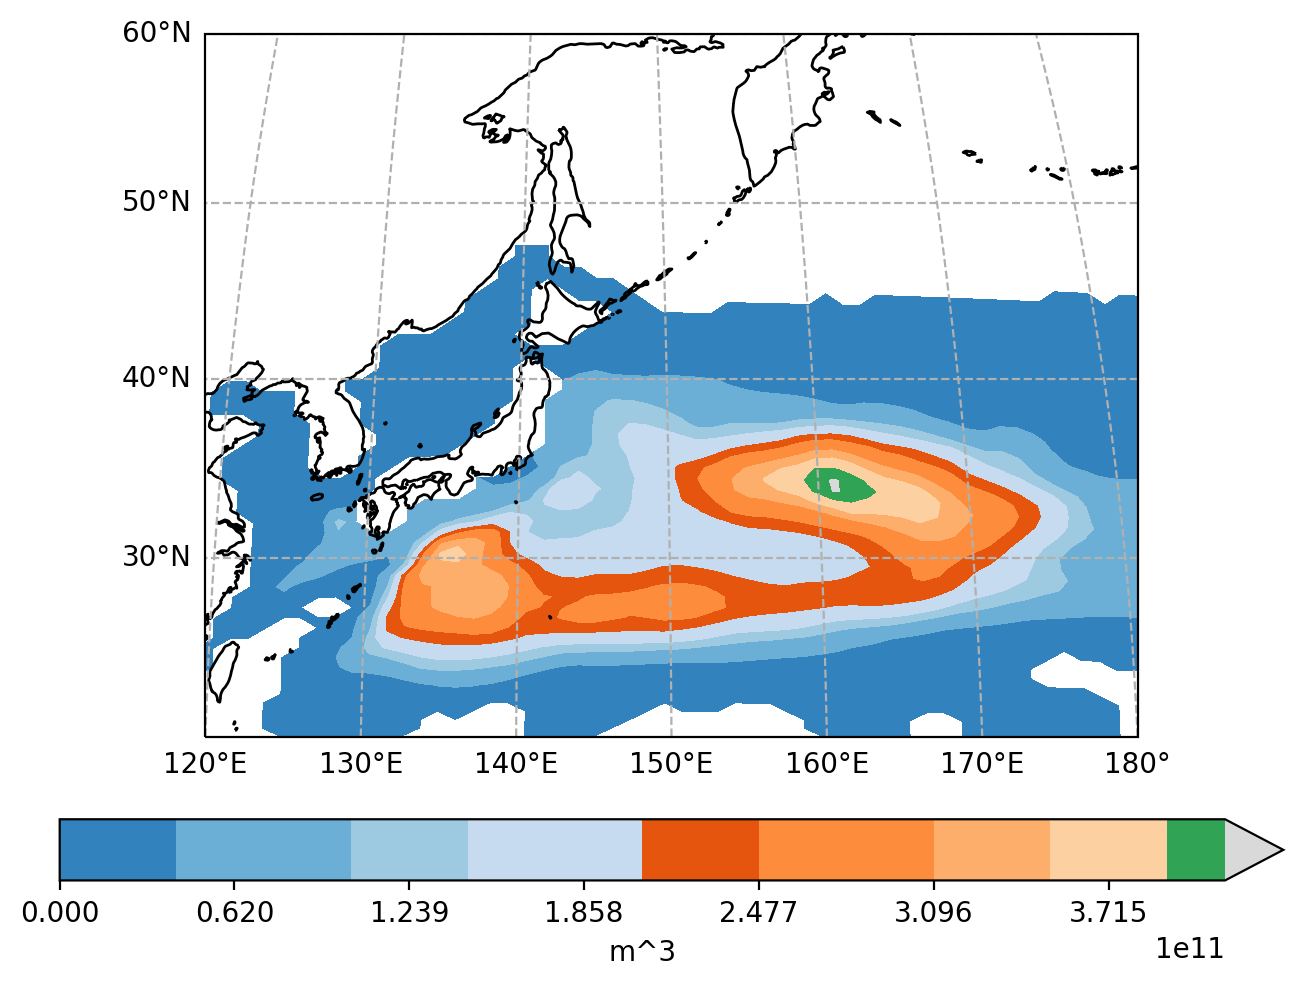

In [20]:
# std STMW (ODA)
compute_edw_volume(cfg_var_TEMP.ODA_ds, ds_grid)
data2 = cfg_var_TEMP.ODA_ds['edw_total_volume']
data2 = data2.groupby('time.year').mean(dim='time').std(dim='year').mean(dim='ens_ODA')

data2 = data2.where(data2 != 0, np.nan).compute()

projection = ccrs.Robinson(central_longitude=145)
fig, axes = plt.subplots(nrows=1, ncols=1, 
             dpi=200, facecolor='w', edgecolor='k', subplot_kw={'projection': projection}, constrained_layout=True)
axes.set_extent([120, 180, 20, 60], crs=ccrs.PlateCarree())  # Longitude range (120 to 170), Latitude range (0 to 50)

# levels = np.linspace(plt1.get_clim()[0], plt1.get_clim()[1], 21)  # 20 intervals
levels = np.linspace(np.nanmin(data1), np.nanmax(data1), 21)  # 20 intervals


plt1=axes.contourf(ds_grid.TLONG[220:325, 132:205],
             ds_grid.TLAT[220:325, 132:205],
             data2,transform=ccrs.PlateCarree(), levels=levels, cmap=cmap, vmin=0, vmax=1e12, add_colorbar=False, extend = 'max')
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=plt1.cmap.N, clip=True)
cbar1 = fig.colorbar(plt1, orientation='horizontal', boundaries=levels, norm=norm)
cbar1.set_label('m^3')
axes.coastlines()
# Adding gridlines
gl = axes.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linestyle='--')
gl.top_labels = False  # Hide top labels
gl.right_labels = False  # Hide right labels
gl.xlocator = mticker.FixedLocator(np.arange(120, 190, 10))  # Longitudes every 10°
gl.ylocator = mticker.FixedLocator(np.arange(20, 70, 10))  # Latitudes every 10°
gl.xlabel_style = {'size': 10, 'color': 'black'}  # Customize label style
gl.ylabel_style = {'size': 10, 'color': 'black'}  # Customize label style

# Take annual means

In [ ]:
start_time = time.time()

oda_annual_mean_DIC = cfg_var_DIC.ODA_ds.groupby('time.year').mean(dim='time', skipna=True).compute()
oda_annual_mean_NPP_diat = cfg_var_NPP_diat.ODA_ds.groupby('time.year').mean(dim='time', skipna=True).compute()
oda_annual_mean_NPP_sp = cfg_var_NPP_sp.ODA_ds.groupby('time.year').mean(dim='time', skipna=True).compute()
oda_annual_mean_Li_diat = cfg_var_Li_diat.ODA_ds.groupby('time.year').mean(dim='time', skipna=True).compute()
oda_annual_mean_Li_sp = cfg_var_Li_sp.ODA_ds.groupby('time.year').mean(dim='time', skipna=True).compute()
oda_annual_mean_temp = cfg_var_temp.ODA_ds.groupby('time.year').mean(dim='time', skipna=True).compute()


timstd_DIC = cfg_var_DIC.ODA_ds.std(dim='time', skipna=True).mean(dim='ens_ODA').compute()
timstd_NPP_diat = cfg_var_NPP_diat.ODA_ds.std(dim='time', skipna=True).mean(dim='ens_ODA').compute()
timstd_NPP_diat['ratio'] = timstd_NPP_diat[cfg_var_NPP_diat.var] / timstd_DIC[cfg_var_DIC.var]
timstd_NPP_sp = cfg_var_NPP_sp.ODA_ds.std(dim='time', skipna=True).mean(dim='ens_ODA').compute()
timstd_NPP_sp['ratio'] = timstd_NPP_sp[cfg_var_NPP_sp.var] / timstd_DIC[cfg_var_DIC.var]

ref_time=cfg_var_DIC.ODA_ds.time.groupby('time.year').mean(dim='time')

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading ODA: ' + str(elapsed_time))

In [ ]:
start_time = time.time()


oda_annual_mean_Vi_diat_Fe = cfg_var_Vi_diat_Fe.ODA_ds.groupby('time.year').mean(dim='time', skipna=True).compute()
oda_annual_mean_Vi_diat_N = cfg_var_Vi_diat_N.ODA_ds.groupby('time.year').mean(dim='time', skipna=True).compute()
oda_annual_mean_Vi_diat_P = cfg_var_Vi_diat_P.ODA_ds.groupby('time.year').mean(dim='time', skipna=True).compute()
oda_annual_mean_Vi_diat_SiO3 = cfg_var_Vi_diat_SiO3.ODA_ds.groupby('time.year').mean(dim='time', skipna=True).compute()
oda_annual_mean_Vi_sp_Fe = cfg_var_Vi_sp_Fe.ODA_ds.groupby('time.year').mean(dim='time', skipna=True).compute()
oda_annual_mean_Vi_sp_N = cfg_var_Vi_sp_N.ODA_ds.groupby('time.year').mean(dim='time', skipna=True).compute()
oda_annual_mean_Vi_sp_P = cfg_var_Vi_sp_P.ODA_ds.groupby('time.year').mean(dim='time', skipna=True).compute()

# diat 계산
Vi_diat_data = xr.concat(
    [oda_annual_mean_Vi_diat_Fe[cfg_var_Vi_diat_Fe.var], oda_annual_mean_Vi_diat_N[cfg_var_Vi_diat_N.var], 
     oda_annual_mean_Vi_diat_P[cfg_var_Vi_diat_P.var], oda_annual_mean_Vi_diat_SiO3[cfg_var_Vi_diat_SiO3.var]],
    dim='source'
)
oda_annual_mean_Vi_diat = Vi_diat_data.min(dim='source')
Vi_diat_data_no_nan = Vi_diat_data.where(Vi_diat_data.notnull(), other=float('inf'))
oda_annual_mean_Vi_diat_index = Vi_diat_data_no_nan.argmin(dim='source') + 1
# oda_annual_mean_Vi_diat_index = Vi_diat_data.argmin(dim='source') + 1
oda_annual_mean_Vi_diat.compute()
oda_annual_mean_Vi_diat_index.compute()

# sp 계산
Vi_sp_data = xr.concat(
    [oda_annual_mean_Vi_sp_Fe[cfg_var_Vi_sp_Fe.var], oda_annual_mean_Vi_sp_N[cfg_var_Vi_sp_N.var], 
     oda_annual_mean_Vi_sp_P[cfg_var_Vi_sp_P.var]],
    dim='source'
)
oda_annual_mean_Vi_sp = Vi_sp_data.min(dim='source')
Vi_sp_data_no_nan = Vi_sp_data.where(Vi_sp_data.notnull(), other=float('inf'))
oda_annual_mean_Vi_sp_index = Vi_sp_data_no_nan.argmin(dim='source') + 1
# oda_annual_mean_Vi_sp_index = Vi_sp_data.argmin(dim='source') + 1
oda_annual_mean_Vi_sp.compute()
oda_annual_mean_Vi_sp_index.compute()

ref_time=cfg_var_Vi_diat_Fe.ODA_ds.time.groupby('time.year').mean(dim='time')

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading ODA: ' + str(elapsed_time))

In [ ]:
# start_time = time.time()

# oda_annual_mean_NPP_diat = cfg_var_NPP_diat.ODA_ds.groupby('time.year').mean(dim='time', skipna=True).compute()
# oda_annual_mean_NPP_sp = cfg_var_NPP_sp.ODA_ds.groupby('time.year').mean(dim='time', skipna=True).compute()

# ref_time=cfg_var_NPP_diat.ODA_ds.time.groupby('time.year').mean(dim='time')

# end_time = time.time()
# elapsed_time = end_time - start_time
# print('elasped time for reading ODA: ' + str(elapsed_time))

In [ ]:
start_time = time.time()

corr_temp = xr.corr(oda_annual_mean_temp[cfg_var_temp.var], oda_annual_mean_DIC[cfg_var_DIC.var], dim='year').compute()
corr_temp_diat = xr.corr(oda_annual_mean_temp[cfg_var_temp.var], oda_annual_mean_NPP_diat[cfg_var_NPP_diat.var], dim='year').compute()
corr_temp_sp = xr.corr(oda_annual_mean_temp[cfg_var_temp.var], oda_annual_mean_NPP_sp[cfg_var_NPP_sp.var], dim='year').compute()
corr_Li_diat = xr.corr(oda_annual_mean_Li_diat[cfg_var_Li_diat.var], oda_annual_mean_NPP_diat[cfg_var_NPP_diat.var], dim='year').compute()
corr_Li_sp = xr.corr(oda_annual_mean_Li_sp[cfg_var_Li_sp.var], oda_annual_mean_NPP_sp[cfg_var_NPP_sp.var], dim='year').compute()
corr_Vi_diat = xr.corr(oda_annual_mean_Vi_diat, oda_annual_mean_NPP_diat[cfg_var_NPP_diat.var], dim='year').compute()
corr_Vi_sp = xr.corr(oda_annual_mean_Vi_sp, oda_annual_mean_NPP_sp[cfg_var_NPP_sp.var], dim='year').compute()
corr_temp_Li_diat = xr.corr(oda_annual_mean_temp[cfg_var_temp.var], oda_annual_mean_Li_diat[cfg_var_Li_diat.var], dim='year').compute()
corr_temp_Li_sp = xr.corr(oda_annual_mean_temp[cfg_var_temp.var], oda_annual_mean_Li_sp[cfg_var_Li_sp.var], dim='year').compute()
corr_temp_Vi_diat = xr.corr(oda_annual_mean_temp[cfg_var_temp.var], oda_annual_mean_Vi_diat, dim='year').compute()
corr_temp_Vi_sp = xr.corr(oda_annual_mean_temp[cfg_var_temp.var], oda_annual_mean_Vi_sp, dim='year').compute()
corr_Vi_diat_Li_diat = xr.corr(oda_annual_mean_Vi_diat, oda_annual_mean_Li_diat[cfg_var_Li_diat.var], dim='year').compute()
corr_Vi_sp_Li_sp = xr.corr(oda_annual_mean_Vi_sp, oda_annual_mean_Li_sp[cfg_var_Li_sp.var], dim='year').compute()


end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading ODA: ' + str(elapsed_time))

In [ ]:
# trends
# start_time = time.time()

# def linear_trend(year, x):
#     # np.polyfit에서 NaN 값 처리
#     valid = ~np.isnan(x)
#     if np.sum(valid) < 2:  # 데이터가 충분하지 않을 경우 추세 계산 불가
#         return np.nan
#     p = np.polyfit(year[valid], x[valid], 1)  # 1차 다항식 추세 계산
#     return p[0]  # 기울기 반환

# # Apply the function to calculate trends over time
# trend_DIC = xr.apply_ufunc(
#     linear_trend, 
#     oda_annual_mean_DIC['year'], 
#     oda_annual_mean_DIC[cfg_var_DIC.var],
#     vectorize=True,  # 벡터화된 함수를 각 좌표마다 적용
#     dask='parallelized',  # dask를 사용하여 병렬화 (옵션)
#     input_core_dims=[['year'], ['year']],  # 시간축을 기준으로 함수 적용
#     output_dtypes=[float],  # 출력 데이터 유형을 지정
# ).compute()

# trend_NPP_diat = xr.apply_ufunc(
#     linear_trend, 
#     oda_annual_mean_NPP_diat['year'], 
#     oda_annual_mean_NPP_diat[cfg_var_NPP_diat.var],
#     vectorize=True,  # 벡터화된 함수를 각 좌표마다 적용
#     dask='parallelized',  # dask를 사용하여 병렬화 (옵션)
#     input_core_dims=[['year'], ['year']],  # 시간축을 기준으로 함수 적용
#     output_dtypes=[float],  # 출력 데이터 유형을 지정
# ).compute()

# trend_NPP_sp = xr.apply_ufunc(
#     linear_trend, 
#     oda_annual_mean_NPP_sp['year'], 
#     oda_annual_mean_NPP_sp[cfg_var_NPP_sp.var],
#     vectorize=True,  # 벡터화된 함수를 각 좌표마다 적용
#     dask='parallelized',  # dask를 사용하여 병렬화 (옵션)
#     input_core_dims=[['year'], ['year']],  # 시간축을 기준으로 함수 적용
#     output_dtypes=[float],  # 출력 데이터 유형을 지정
# ).compute()

# trend_temp = xr.apply_ufunc(
#     linear_trend, 
#     oda_annual_mean_temp['year'], 
#     oda_annual_mean_temp[cfg_var_temp.var],
#     vectorize=True,  # 벡터화된 함수를 각 좌표마다 적용
#     dask='parallelized',  # dask를 사용하여 병렬화 (옵션)
#     input_core_dims=[['year'], ['year']],  # 시간축을 기준으로 함수 적용
#     output_dtypes=[float],  # 출력 데이터 유형을 지정
# ).compute()

# end_time = time.time()
# elapsed_time = end_time - start_time
# print('elasped time for reading ODA: ' + str(elapsed_time))

In [ ]:
# define pop funtion for figure

def pop_add_cyclic(da):
        #copied from Mattew Longs github (https://gist.github.com/matt-long/50433da346da8ac17cde926eec90a87c) and modified for DA
        #This doesn't work with Dask (DA should be loaded)
        #Input DA must have the name and coords (TLONG and TLAT), and don't have other dims (time etc.)
        #Output is DA
        nj = da.TLAT.shape[0]
        ni = da.TLONG.shape[1]
        xL = int(ni/2 - 1)
        xR = int(xL + ni)
        tlon = da.TLONG.data
        tlat = da.TLAT.data
        tlon = np.where(np.greater_equal(tlon, min(tlon[:,0])), tlon-360., tlon)
        lon  = np.concatenate((tlon, tlon + 360.), 1)
        lon = lon[:, xL:xR]
        if ni == 320:
            lon[367:-3, 0] = lon[367:-3, 0] + 360.
        lon = lon - 360.
        lon = np.hstack((lon, lon[:, 0:1] + 360.))
        if ni == 320:
            lon[367:, -1] = lon[367:, -1] - 360.
        #-- trick cartopy into doing the right thing:
        #   it gets confused when the cyclic coords are identical
        lon[:, 0] = lon[:, 0] - 1e-8
        #-- periodicity
        lat = np.concatenate((tlat, tlat), 1)
        lat = lat[:, xL:xR]
        lat = np.hstack((lat, lat[:,0:1]))
        TLAT = xr.DataArray(lat, dims=('nlat', 'nlon'))
        TLONG = xr.DataArray(lon, dims=('nlat', 'nlon'))
        # copy vars
        v = da.name
        v_dims = da.dims
        # determine and sort other dimensions
        other_dims = set(v_dims) - {'nlat', 'nlon'}
        other_dims = tuple([d for d in v_dims if d in other_dims])
        lon_dim = da.dims.index('nlon')
        field = da.data
        field = np.concatenate((field, field), lon_dim)
        field = field[:, xL:xR]
        field = np.concatenate((field, field[:, 0:1]), lon_dim)
        dao = xr.DataArray(field, dims=other_dims+('nlat', 'nlon'), attrs=da.attrs)
        dao = dao.assign_coords(TLONG=TLONG)
        dao = dao.assign_coords(TLAT=TLAT)
        return dao

In [ ]:
# plot for NPP_ratio (mean)

start_time = time.time()

varn=cfg_var_DIC.var #example

if cfg_var_DIC.comp=='ocn':
    ds_grid = pop_tools.get_grid('POP_gx1v7')

cmap = cm.vik
# cmap = plt.cm.viridis  

levels = np.linspace(-1, 1, 11) # -1 ~ 1, 20 levels
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N, clip=True)
projection = ccrs.Robinson(central_longitude=200)

fig, axes = plt.subplots(nrows=3, ncols=2, 
             dpi=200, facecolor='w', edgecolor='k', subplot_kw={'projection': projection}, constrained_layout=False)
# fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18.5, 9), 
#              dpi=200, facecolor='w', edgecolor='k', subplot_kw={'projection': projection}, constrained_layout=False)

# # fig1: T_f
# data_array=corr_temp.mean(dim='ens_ODA')
# data_array['TLONG']=ds_grid.TLONG
# data_array['TLAT']=ds_grid.TLAT

# plt1=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[2,0], 
#                         transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)

# axes[2,0].set_title('T_f <-> NPP(TOT)')
# axes[0].gridlines(draw_labels=True) 
# axes[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}°'))
# axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}°'))

# fig1: T_f (diat)
data_array=corr_temp_diat.mean(dim='ens_ODA')
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT
plt1=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[2,0], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)

axes[2,0].set_title('T_f <-> NPP(diat)')

# fig1: T_f (diat)
data_array=corr_temp_sp.mean(dim='ens_ODA')
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT
plt1=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[2,1], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)

axes[2,1].set_title('T_f <-> NPP(sp)')


# fig2: Li_diat
data_array=corr_Li_diat.mean(dim='ens_ODA')
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT

plt2=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[0,0], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)
axes[0,0].set_title('Li(diat) <-> NPP(diat)')

# fig3: Li_sp
data_array=corr_Li_sp.mean(dim='ens_ODA')
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT

plt3=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[0,1], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)
axes[0,1].set_title('Li(sp) <-> NPP(sp)')

# fig4: Vi_diat
data_array=corr_Vi_diat.mean(dim='ens_ODA')
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT

plt4=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[1,0], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)
axes[1,0].set_title('Vi(diat) <-> NPP(diat)')

# fig4: Vi_sp
data_array=corr_Vi_sp.mean(dim='ens_ODA')
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT

plt4=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[1,1], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)
axes[1,1].set_title('Vi(sp) <-> NPP(sp)')

# axes[2,1].set_visible(False)

plt.rcParams.update({'font.size': 8.5})

cbar_a_c = fig.add_axes([0.9, 0.1, 0.01, 0.8])  # [left, bottom, width, height] 비율로 컬러바 위치와 크기 설정
cbar1 = fig.colorbar(plt1, cax=cbar_a_c, orientation='vertical')
cbar1.set_label('R')

plt.subplots_adjust(hspace=0.3, wspace=0.05)  # hspace: 세로 간격, wspace: 가로 간격

plt.show()

end_time = time.time()
elapsed_time = end_time - start_time
# print('elasped time for calculating correlation: ' + str(elapsed_time))

In [ ]:
# plot for NPP_ratio (mean)

start_time = time.time()

varn=cfg_var_DIC.var #example

if cfg_var_DIC.comp=='ocn':
    ds_grid = pop_tools.get_grid('POP_gx1v7')

cmap = cm.vik
# cmap = plt.cm.viridis  

levels = np.linspace(-1, 1, 11) # -1 ~ 1, 20 levels
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N, clip=True)
projection = ccrs.Robinson(central_longitude=200)

fig, axes = plt.subplots(nrows=3, ncols=2, 
             dpi=200, facecolor='w', edgecolor='k', subplot_kw={'projection': projection}, constrained_layout=False)
# fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18.5, 9), 
#              dpi=200, facecolor='w', edgecolor='k', subplot_kw={'projection': projection}, constrained_layout=False)

# # fig1: T_f
# data_array=corr_temp.mean(dim='ens_ODA')
# data_array['TLONG']=ds_grid.TLONG
# data_array['TLAT']=ds_grid.TLAT

# plt1=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[2,0], 
#                         transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)

# axes[2,0].set_title('T_f <-> NPP(TOT)')
# axes[0].gridlines(draw_labels=True) 
# axes[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}°'))
# axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}°'))

# fig1: T_f and Li (diat)
data_array=corr_temp_Li_diat.mean(dim='ens_ODA')
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT
plt1=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[0,0], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)

axes[0,0].set_title('T_f <-> Li(diat)')

# fig2: T_f and Li (sp)
data_array=corr_temp_Li_sp.mean(dim='ens_ODA')
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT
plt2=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[0,1], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)

axes[0,1].set_title('T_f <-> Li(sp)')

# fig3: T_f and Li (diat)
data_array=corr_temp_Vi_diat.mean(dim='ens_ODA')
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT
plt3=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[1,0], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)

axes[1,0].set_title('T_f <-> Vi(diat)')

# fig4: T_f and Li (sp)
data_array=corr_temp_Vi_sp.mean(dim='ens_ODA')
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT
plt4=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[1,1], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)

axes[1,1].set_title('T_f <-> Vi(sp)')


# fig5: Vi and Li (diat)
data_array=corr_Vi_diat_Li_diat.mean(dim='ens_ODA')
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT
plt3=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[2,0], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)

axes[2,0].set_title('Li(diat) <-> Vi(diat)')

# fig6: Vi and Li (sp)
data_array=corr_Vi_sp_Li_sp.mean(dim='ens_ODA')
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT
plt4=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[2,1], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)

axes[2,1].set_title('Li(sp) <-> Vi(sp)')



plt.rcParams.update({'font.size': 8.5})

cbar_a_c = fig.add_axes([0.9, 0.1, 0.01, 0.8])  # [left, bottom, width, height] 비율로 컬러바 위치와 크기 설정
cbar1 = fig.colorbar(plt1, cax=cbar_a_c, orientation='vertical')
cbar1.set_label('R')

plt.subplots_adjust(hspace=0.3, wspace=0.05)  # hspace: 세로 간격, wspace: 가로 간격

plt.show()

end_time = time.time()
elapsed_time = end_time - start_time
# print('elasped time for calculating correlation: ' + str(elapsed_time))

In [ ]:
# plot for NPP_ratio (mean)

start_time = time.time()

varn=cfg_var_DIC.var #example

if cfg_var_DIC.comp=='ocn':
    ds_grid = pop_tools.get_grid('POP_gx1v7')

cmap = cm.vik
# cmap = plt.cm.viridis  

levels = np.linspace(-1, 1, 11) # -1 ~ 1, 20 levels
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N, clip=True)
projection = ccrs.Robinson(central_longitude=200)

fig, axes = plt.subplots(nrows=3, ncols=2, 
             dpi=200, facecolor='w', edgecolor='k', subplot_kw={'projection': projection}, constrained_layout=False)


mask_land = np.isnan(corr_temp_diat.mean(dim='ens_ODA'))  # 육지(NaN인 지역)
mask_land_numeric = mask_land.astype(int)


# fig1: T_f (diat)
data_array=corr_temp_diat.where(timstd_NPP_diat['ratio'] >= 0.8).mean(dim='ens_ODA')
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT
mask_land_numeric['TLONG']=ds_grid.TLONG
mask_land_numeric['TLAT']=ds_grid.TLAT


plt1=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[2,0], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)
land1 = pop_add_cyclic(mask_land_numeric.where(mask_land_numeric == 1, np.nan)).plot.pcolormesh(ax = axes[2,0], x='TLONG', y='TLAT', 
                  transform=ccrs.PlateCarree(), cmap='Greys', add_colorbar=False)


axes[2,0].set_title('T_f <-> NPP(diat)')

# fig2: T_f (diat)
data_array=corr_temp_sp.where(timstd_NPP_sp['ratio'] >= 0.8).mean(dim='ens_ODA')
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT
plt2=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[2,1], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)
land2 = pop_add_cyclic(mask_land_numeric.where(mask_land_numeric == 1, np.nan)).plot.pcolormesh(ax = axes[2,1], x='TLONG', y='TLAT', 
                  transform=ccrs.PlateCarree(), cmap='Greys', add_colorbar=False)

axes[2,1].set_title('T_f <-> NPP(sp)')


# fig3: Li_diat
data_array=corr_Li_diat.where(timstd_NPP_diat['ratio'] >= 0.8).mean(dim='ens_ODA')
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT

plt3=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[0,0], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)
land3 = pop_add_cyclic(mask_land_numeric.where(mask_land_numeric == 1, np.nan)).plot.pcolormesh(ax = axes[0,0], x='TLONG', y='TLAT', 
                  transform=ccrs.PlateCarree(), cmap='Greys', add_colorbar=False)
axes[0,0].set_title('Li(diat) <-> NPP(diat)')

# fig4: Li_sp
data_array=corr_Li_sp.where(timstd_NPP_sp['ratio'] >= 0.8).mean(dim='ens_ODA')
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT

plt4=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[0,1], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)
land4 = pop_add_cyclic(mask_land_numeric.where(mask_land_numeric == 1, np.nan)).plot.pcolormesh(ax = axes[0,1], x='TLONG', y='TLAT', 
                  transform=ccrs.PlateCarree(), cmap='Greys', add_colorbar=False)
axes[0,1].set_title('Li(sp) <-> NPP(sp)')

# fig5: Vi_diat
data_array=corr_Vi_diat.where(timstd_NPP_diat['ratio'] >= 0.8).mean(dim='ens_ODA')
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT

plt5=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[1,0], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)
land5 = pop_add_cyclic(mask_land_numeric.where(mask_land_numeric == 1, np.nan)).plot.pcolormesh(ax = axes[1,0], x='TLONG', y='TLAT', 
                  transform=ccrs.PlateCarree(), cmap='Greys', add_colorbar=False)
axes[1,0].set_title('Vi(diat) <-> NPP(diat)')

# fig6: Vi_sp
data_array=corr_Vi_sp.where(timstd_NPP_sp['ratio'] >= 0.8).mean(dim='ens_ODA')
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT

plt6=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[1,1], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)
land6 = pop_add_cyclic(mask_land_numeric.where(mask_land_numeric == 1, np.nan)).plot.pcolormesh(ax = axes[1,1], x='TLONG', y='TLAT', 
                  transform=ccrs.PlateCarree(), cmap='Greys', add_colorbar=False)
axes[1,1].set_title('Vi(sp) <-> NPP(sp)')

# axes[2,1].set_visible(False)

plt.rcParams.update({'font.size': 8.5})

cbar_a_c = fig.add_axes([0.9, 0.1, 0.01, 0.8])  # [left, bottom, width, height] 비율로 컬러바 위치와 크기 설정
cbar1 = fig.colorbar(plt1, cax=cbar_a_c, orientation='vertical')
cbar1.set_label('R')

plt.subplots_adjust(hspace=0.3, wspace=0.05)  # hspace: 세로 간격, wspace: 가로 간격

plt.show()

end_time = time.time()
elapsed_time = end_time - start_time
# print('elasped time for calculating correlation: ' + str(elapsed_time))

In [ ]:
# plot for NPP_ratio (mean)

start_time = time.time()

varn=cfg_var_DIC.var #example

if cfg_var_DIC.comp=='ocn':
    ds_grid = pop_tools.get_grid('POP_gx1v7')

mask_land = np.isnan(corr_temp_diat.mean(dim='ens_ODA'))  # 육지(NaN인 지역)
mask_land_numeric = mask_land.astype(int)
mask_land_numeric['TLONG']=ds_grid.TLONG
mask_land_numeric['TLAT']=ds_grid.TLAT


cmap = cm.vik
# cmap = plt.cm.viridis  

levels = np.linspace(-1, 1, 11) # -1 ~ 1, 20 levels
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N, clip=True)
projection = ccrs.Robinson(central_longitude=200)

fig, axes = plt.subplots(nrows=3, ncols=2, 
             dpi=200, facecolor='w', edgecolor='k', subplot_kw={'projection': projection}, constrained_layout=False)


# fig1: T_f and Li (diat)
data_array=corr_temp_Li_diat.where(timstd_NPP_diat['ratio'] >= 0.8).mean(dim='ens_ODA')
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT
plt1=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[0,0], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)
land1 = pop_add_cyclic(mask_land_numeric.where(mask_land_numeric == 1, np.nan)).plot.pcolormesh(ax = axes[0,0], x='TLONG', y='TLAT', 
                  transform=ccrs.PlateCarree(), cmap='Greys', add_colorbar=False)

axes[0,0].set_title('T_f <-> Li(diat)')

# fig2: T_f and Li (sp)
data_array=corr_temp_Li_sp.where(timstd_NPP_sp['ratio'] >= 0.8).mean(dim='ens_ODA')
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT
plt2=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[0,1], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)
land2 = pop_add_cyclic(mask_land_numeric.where(mask_land_numeric == 1, np.nan)).plot.pcolormesh(ax = axes[0,1], x='TLONG', y='TLAT', 
                  transform=ccrs.PlateCarree(), cmap='Greys', add_colorbar=False)

axes[0,1].set_title('T_f <-> Li(sp)')

# fig3: T_f and Li (diat)
data_array=corr_temp_Vi_diat.where(timstd_NPP_diat['ratio'] >= 0.8).mean(dim='ens_ODA')
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT
plt3=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[1,0], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)
land3 = pop_add_cyclic(mask_land_numeric.where(mask_land_numeric == 1, np.nan)).plot.pcolormesh(ax = axes[1,0], x='TLONG', y='TLAT', 
                  transform=ccrs.PlateCarree(), cmap='Greys', add_colorbar=False)

axes[1,0].set_title('T_f <-> Vi(diat)')

# fig4: T_f and Li (sp)
data_array=corr_temp_Vi_sp.where(timstd_NPP_sp['ratio'] >= 0.8).mean(dim='ens_ODA')
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT
plt4=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[1,1], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)
land4 = pop_add_cyclic(mask_land_numeric.where(mask_land_numeric == 1, np.nan)).plot.pcolormesh(ax = axes[1,1], x='TLONG', y='TLAT', 
                  transform=ccrs.PlateCarree(), cmap='Greys', add_colorbar=False)

axes[1,1].set_title('T_f <-> Vi(sp)')


# fig5: Vi and Li (diat)
data_array=corr_Vi_diat_Li_diat.where(timstd_NPP_diat['ratio'] >= 0.8).mean(dim='ens_ODA')
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT
plt5=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[2,0], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)
land5 = pop_add_cyclic(mask_land_numeric.where(mask_land_numeric == 1, np.nan)).plot.pcolormesh(ax = axes[2,0], x='TLONG', y='TLAT', 
                  transform=ccrs.PlateCarree(), cmap='Greys', add_colorbar=False)

axes[2,0].set_title('Li(diat) <-> Vi(diat)')

# fig6: Vi and Li (sp)
data_array=corr_Vi_sp_Li_sp.where(timstd_NPP_sp['ratio'] >= 0.8).mean(dim='ens_ODA')
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT
plt6=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[2,1], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)
land6 = pop_add_cyclic(mask_land_numeric.where(mask_land_numeric == 1, np.nan)).plot.pcolormesh(ax = axes[2,1], x='TLONG', y='TLAT', 
                  transform=ccrs.PlateCarree(), cmap='Greys', add_colorbar=False)

axes[2,1].set_title('Li(sp) <-> Vi(sp)')



plt.rcParams.update({'font.size': 8.5})

cbar_a_c = fig.add_axes([0.9, 0.1, 0.01, 0.8])  # [left, bottom, width, height] 비율로 컬러바 위치와 크기 설정
cbar1 = fig.colorbar(plt1, cax=cbar_a_c, orientation='vertical')
cbar1.set_label('R')

plt.subplots_adjust(hspace=0.3, wspace=0.05)  # hspace: 세로 간격, wspace: 가로 간격

plt.show()

end_time = time.time()
elapsed_time = end_time - start_time
# print('elasped time for calculating correlation: ' + str(elapsed_time))

In [ ]:
# oda_annual_mean_Vi_diat_index

start_time = time.time()

def find_majority_value_diat(data, threshold=0.8):
    # 값 1, 2, 3, 4 각각에 대해 year 축을 따라 비율 계산
    counts_1 = (data == 1).sum(dim='year')
    counts_2 = (data == 2).sum(dim='year')
    counts_3 = (data == 3).sum(dim='year')
    counts_4 = (data == 4).sum(dim='year')
    
    # 전체 year 수 (NaN이 아닌 값에 대해서만)
    valid_years = data.notnull().sum(dim='year')

    # 각 값에 대한 비율 계산 (NaN을 제외한 비율)
    ratio_1 = counts_1 / valid_years
    ratio_2 = counts_2 / valid_years
    ratio_3 = counts_3 / valid_years
    ratio_4 = counts_4 / valid_years
    
    # 결과를 저장할 배열을 NaN으로 초기화
    result = xr.full_like(counts_1, np.nan)
    
    # 80% 이상 비율을 차지하는 값을 선택
    result = xr.where(ratio_1 >= threshold, 1, result)
    result = xr.where(ratio_2 >= threshold, 2, result)
    result = xr.where(ratio_3 >= threshold, 3, result)
    result = xr.where(ratio_4 >= threshold, 4, result)

    # 모든 값이 NaN일 경우에는 NaN 유지, 80%를 넘는 값이 없을 경우 5로 설정
    result = xr.where((valid_years > 0) & result.isnull(), 5, result)
    
    return result

# 함수 적용
oda_majority_diat = find_majority_value_diat(oda_annual_mean_Vi_diat_index)
oda_majority_sp = find_majority_value_diat(oda_annual_mean_Vi_sp_index)

end_time = time.time()
elapsed_time = end_time - start_time

In [ ]:

# plot for NPP_ratio (mean)

start_time = time.time()

varn=cfg_var_DIC.var #example

if cfg_var_DIC.comp=='ocn':
    ds_grid = pop_tools.get_grid('POP_gx1v7')

mask_land = np.isnan(corr_temp_diat.mean(dim='ens_ODA'))  # 육지(NaN인 지역)
mask_land_numeric = mask_land.astype(int)
mask_land_numeric['TLONG']=ds_grid.TLONG
mask_land_numeric['TLAT']=ds_grid.TLAT


# cmap = cm.vik
# cmap = plt.cm.viridis
# pastel_colors = ['#FFB3BA', '#FFDFBA', '#FFFFBA', '#BAFFC9', '#BAE1FF']  # Pastel 톤 색상 리스트
# cmap = mcolors.ListedColormap(pastel_colors)
# cmap = plt.get_cmap('Accent')
# cmap = plt.get_cmap('tab10')
colors = ['red', '#77DD77', 'black', 'orange']
cmap = mcolors.ListedColormap(colors)

levels = np.linspace(1, 5, 5) # 1~4, 4 levels Fe, N, P Si, Competition
# levels = np.linspace(1, 5, 6) # 1~5, 5 levels Fe, N, P Si, Competition

norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N, clip=True)
projection = ccrs.Robinson(central_longitude=200)

fig, axes = plt.subplots(nrows=2, ncols=1, 
             dpi=200, facecolor='w', edgecolor='k', subplot_kw={'projection': projection}, constrained_layout=False)


# fig1: Major nutrient (diat)
data_array=oda_majority_diat.where(timstd_NPP_diat['ratio'] >= 0.8).mean(dim='ens_ODA').round()
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT
plt1=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[0], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)
land1 = pop_add_cyclic(mask_land_numeric.where(mask_land_numeric == 1, np.nan)).plot.pcolormesh(ax = axes[0], x='TLONG', y='TLAT', 
                  transform=ccrs.PlateCarree(), cmap='Greys', add_colorbar=False)

axes[0].set_title('Primary Limiting Nutrient (diat)')


# fig2: Major nutrient (sp)
data_array=oda_majority_sp.where(timstd_NPP_sp['ratio'] >= 0.8).mean(dim='ens_ODA').round()
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT
plt1=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=axes[1], 
                        transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)
land1 = pop_add_cyclic(mask_land_numeric.where(mask_land_numeric == 1, np.nan)).plot.pcolormesh(ax = axes[1], x='TLONG', y='TLAT', 
                  transform=ccrs.PlateCarree(), cmap='Greys', add_colorbar=False)

axes[1].set_title('Primary Limiting Nutrient (sp)')



plt.rcParams.update({'font.size': 8.5})

cbar_a_c = fig.add_axes([0.9, 0.1, 0.01, 0.8])  # [left, bottom, width, height] 비율로 컬러바 위치와 크기 설정
cbar1 = fig.colorbar(plt1, cax=cbar_a_c, orientation='vertical')
cbar1.set_label('Primary Limiting Nutrient')
cbar1.set_ticks([1.5, 2.5, 3.5, 4.5])  # 각 라벨의 위치를 조정
# cbar1.set_ticklabels(['Fe', 'N', 'P', 'SiO3', 'Competition'])  # 라벨 변경
cbar1.set_ticklabels(['Fe', 'N', 'P', 'SiO3'])  # 라벨 변경



plt.show()

end_time = time.time()
elapsed_time = end_time - start_time